In [30]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time


In [31]:
#  Parametrlər və Setup:

In [32]:
base_url = "https://turbo.az"
search_url = f"{base_url}/autos?utf8=%E2%9C%93&q%5Bmake%5D=25&q%5Bmodel%5D%5B%5D=81"  # Hyundai Elantra
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
}


In [33]:
 # 1. Bütün elanların linklərini toplamaq:

In [34]:
def get_listing_links(pages=3):
    links = []
    for page in range(1, pages + 1):
        url = f"{search_url}&page={page}"
        res = requests.get(url, headers=headers)
        soup = BeautifulSoup(res.text, "html.parser")

        ads = soup.find_all("a", class_="products-i__link")
        for ad in ads:
            href = ad.get("href")
            if href:
                full_link = base_url + href
                links.append(full_link)

        time.sleep(1)  # saytı çox yükləməmək üçün
    return links


In [35]:
 # 2. Hər bir elanın detallı məlumatlarını çəkmək:

In [36]:
def scrape_car_data(url):
    try:
        res = requests.get(url, headers=headers)
        soup = BeautifulSoup(res.text, "html.parser")

        # Qiymət
        price_div = soup.find("div", class_="product-price__i")
        if price_div:
            price_text = price_div.text.strip().replace("\n", "").replace(" ", "")
            try:
                if "USD" in price_text:
                    price = int(price_text.replace("USD", "").replace(",", "")) * 1.7
                elif "EUR" in price_text:
                    price = int(price_text.replace("EUR", "").replace(",", "")) * 1.85
                else:
                    price = int(price_text.replace("AZN", "").replace(",", ""))
            except ValueError:
                print(f"⚠️ Qiymət çevrilmə problemi: {price_text}")
                price = None
        else:
            price = None

        # Specs
        specs = soup.find_all("div", class_="product-properties__i")
        info = {}

        for item in specs:
            text = item.get_text(separator="|", strip=True)
            if "|" in text:
                label, value = text.split("|", 1)
                info[label] = value

        return {
            "url": url,
            "price_manat": int(price) if price else None,
            "year": info.get("Buraxılış ili", ""),
            "color": info.get("Rəng", ""),
            "engine": info.get("Mühərrik", "").split(" ")[0],
            "mileage": info.get("Yürüş", "").replace(" km", "").replace(" ", "").replace("min", "000")
        }

    except Exception as e:
        print(f"❗ Problem with {url}: {e}")
        return None


In [41]:
all_links = get_listing_links(pages=100)  
all_data = []

for link in all_links:
    data = scrape_car_data(link)
    if data:
        all_data.append(data)
    time.sleep(0.5)

df = pd.DataFrame(all_data)
df.to_csv("elantra_raw_data.csv", index=False)
df.head()


,url,price_manat,year,color,engine,mileage
0,https://turbo.az/autos/9485160-kia-k5,42330,2022,Boz,1.6,66000
1,https://turbo.az/autos/9533776-bmw-520,106250,2023,Qızılı,2.0,28500
2,https://turbo.az/autos/8801574-bentley-bentayga,491300,2023,Bənövşəyi,4.0,4530
3,https://turbo.az/autos/8850251-changan-qiyuan-q05,31700,2025,Ağ,1.5,0
4,https://turbo.az/autos/8120230-hyundai-avante,25500,2019,Ağ,1.6,121000


In [47]:
df.drop('url',inplace=True,axis=1)

In [48]:
df

,price_manat,year,color,engine,mileage
0,42330,2022.0,Boz,1.6,66000.0
1,106250,2023.0,Qızılı,2.0,28500.0
2,491300,2023.0,Bənövşəyi,4.0,4530.0
3,31700,2025.0,Ağ,1.5,0.0
4,25500,2019.0,Ağ,1.6,121000.0
...,...,...,...,...,...
1595,65000,2024.0,Göy,1.6,2534.0
1596,17000,2007.0,Gümüşü,2.4,288000.0
1597,98600,2018.0,Yaş Asfalt,3.0,130000.0
1598,32500,2016.0,Ağ,2.0,92000.0


# Yaradılan data baza üzərində basic data cleaning əməliyyatları

In [49]:
df.isnull().sum()

price_manat    0
year           0
color          0
engine         0
mileage        0
dtype: int64

In [ ]:
# NUll dəyər yoxdur.

In [50]:
# İl və yürüşü ədədə çevir
df["year"] = df["year"].astype(str).str.extract(r"(\d{4})").astype(float)
df["engine"] = df["engine"].astype(str).str.replace(",", ".").astype(float)
df["mileage"] = df["mileage"].astype(str).str.replace(",", "").astype(float)

# Qiyməti tam ədədə çevir
df["price_manat"] = df["price_manat"].astype(int)

# Təmizlənmiş DataFrame-ə baxış
df.head()


,price_manat,year,color,engine,mileage
0,42330,2022.0,Boz,1.6,66000.0
1,106250,2023.0,Qızılı,2.0,28500.0
2,491300,2023.0,Bənövşəyi,4.0,4530.0
3,31700,2025.0,Ağ,1.5,0.0
4,25500,2019.0,Ağ,1.6,121000.0


# Ortalama qiymət, buraxılış illərinə görə qiymət dəyişimi , mühərrikin gücü ilə qiymət arasındaki əlaqələri göstərən vizuallar

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
sns.set(style="whitegrid")

# Ortalama qiymət
print("🔢 Ortalama qiymət:", df["price_manat"].mean())

🔢 Ortalama qiymət: 59037.8425


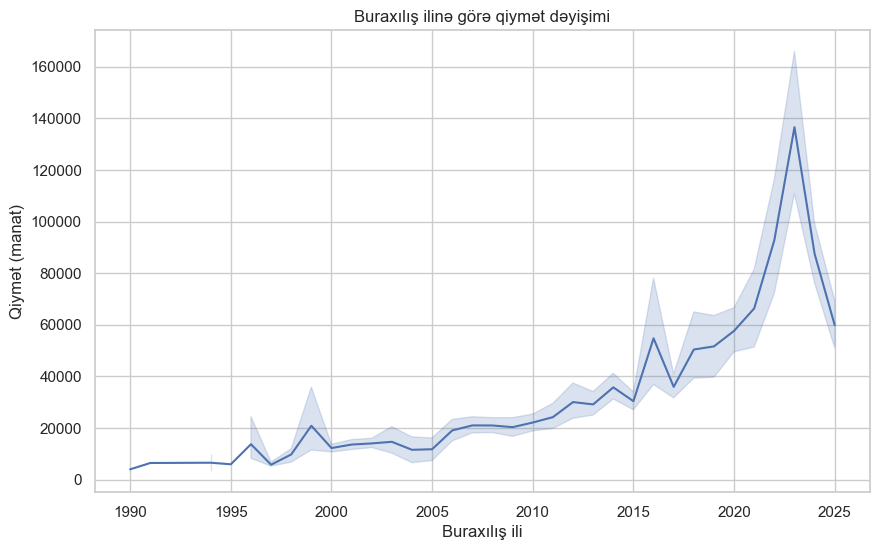

In [53]:
# Buraxılış ilinə görə qiymət dəyişimi
plt.figure(figsize=(10,6))
sns.lineplot(data=df.sort_values("year"), x="year", y="price_manat")
plt.title("Buraxılış ilinə görə qiymət dəyişimi")
plt.ylabel("Qiymət (manat)")
plt.xlabel("Buraxılış ili")
plt.show()

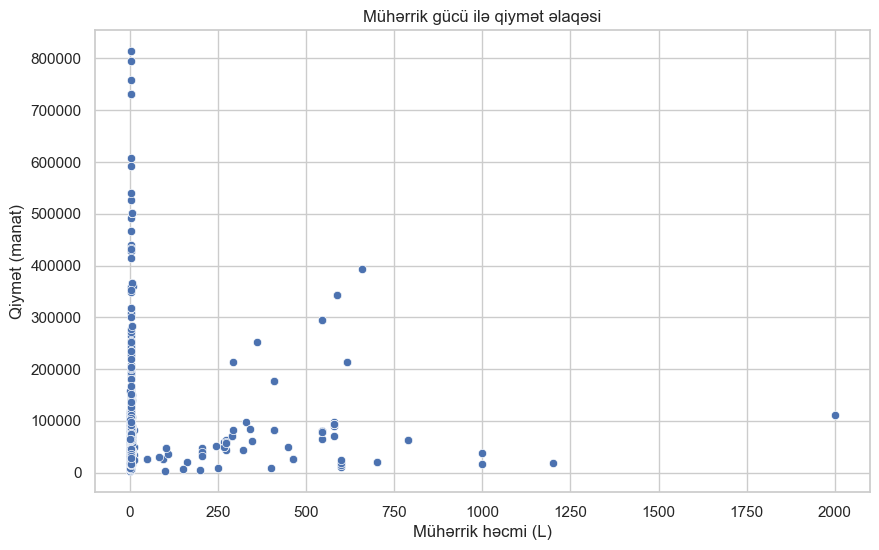

In [54]:
# Mühərrikin gücü ilə qiymət əlaqəsi
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="engine", y="price_manat")
plt.title("Mühərrik gücü ilə qiymət əlaqəsi")
plt.xlabel("Mühərrik həcmi (L)")
plt.ylabel("Qiymət (manat)")
plt.show()

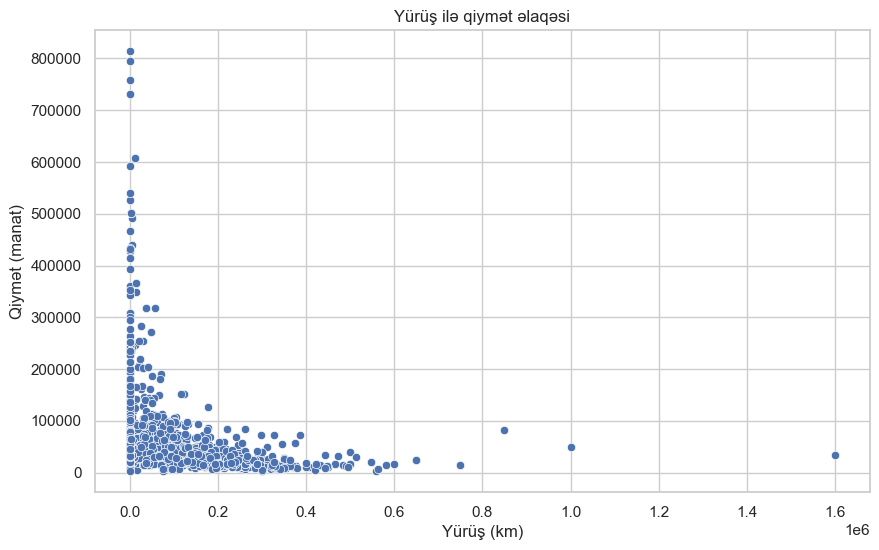

In [56]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="mileage", y="price_manat")
plt.title("Yürüş ilə qiymət əlaqəsi")
plt.xlabel("Yürüş (km)")
plt.ylabel("Qiymət (manat)")
plt.show()

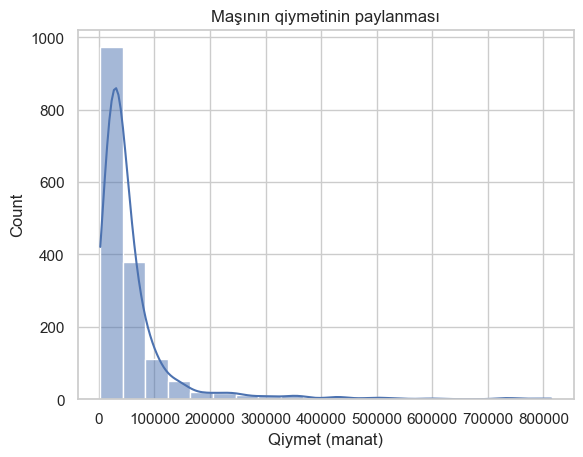

In [62]:
sns.histplot(data=df, x="price_manat", bins=20, kde=True)
plt.title("Maşının qiymətinin paylanması")
plt.xlabel("Qiymət (manat)")
plt.show()


In [63]:
# Normal paylanma deyil. Left-skewed paylanma var.

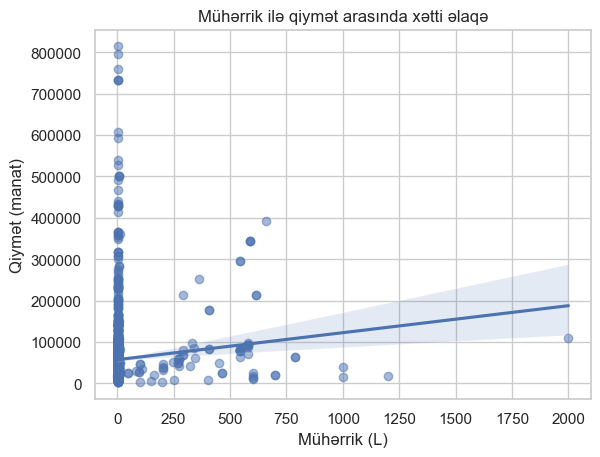

In [64]:
sns.regplot(data=df, x="engine", y="price_manat", scatter_kws={"alpha":0.5})
plt.title("Mühərrik ilə qiymət arasında xətti əlaqə")
plt.xlabel("Mühərrik (L)")
plt.ylabel("Qiymət (manat)")
plt.show()

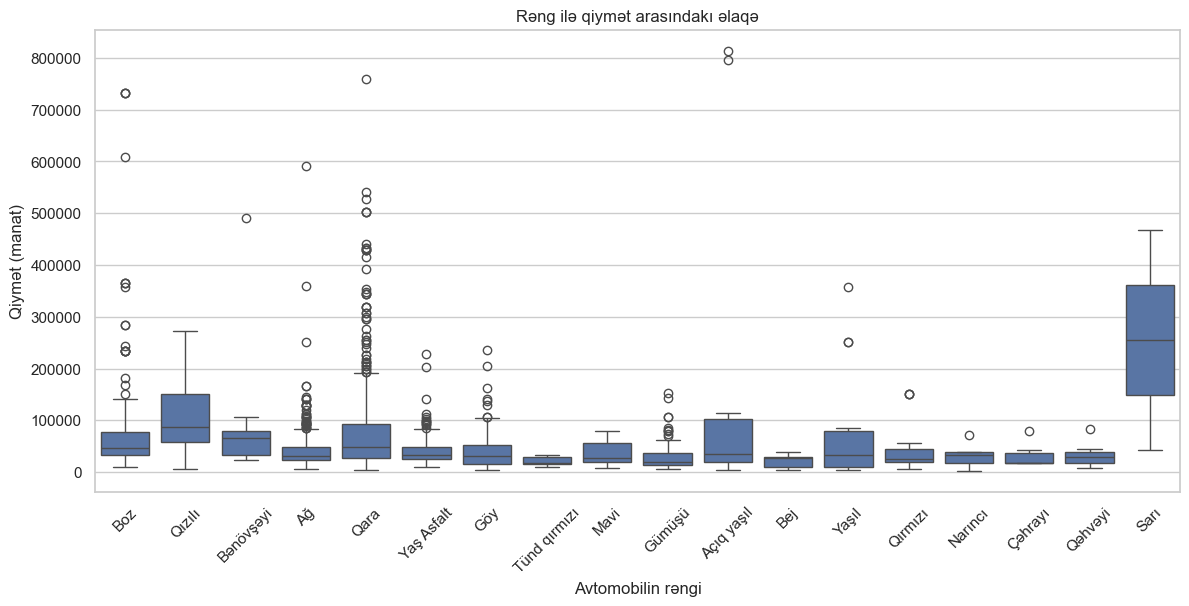

In [65]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x="color", y="price_manat")
plt.title("Rəng ilə qiymət arasındakı əlaqə")
plt.xlabel("Avtomobilin rəngi")
plt.ylabel("Qiymət (manat)")
plt.xticks(rotation=45)  # əgər rəng adları uzundursa
plt.show()


In [ ]:
# outlierler var. Machine Learning tetbiq edeceyikse Outlierleri tenzimlemek lazimdir.

C:\Users\zerif\AppData\Local\Temp\ipykernel_10144\2925986116.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=color_counts.values, y=color_counts.index, palette="pastel")


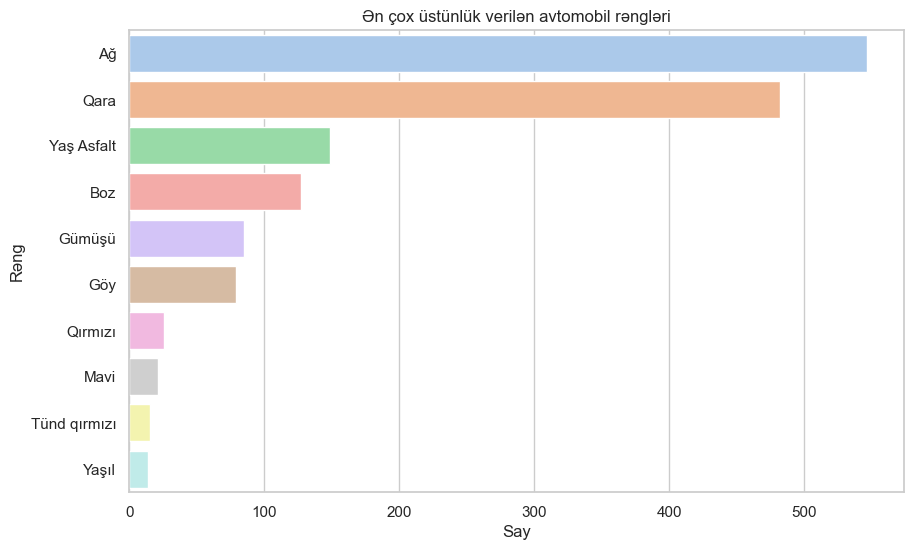

In [66]:
color_counts = df["color"].value_counts().head(10)  # Ən çox olan 10 rəng

plt.figure(figsize=(10, 6))
sns.barplot(x=color_counts.values, y=color_counts.index, palette="pastel")
plt.title("Ən çox üstünlük verilən avtomobil rəngləri")
plt.xlabel("Say")
plt.ylabel("Rəng")
plt.show()

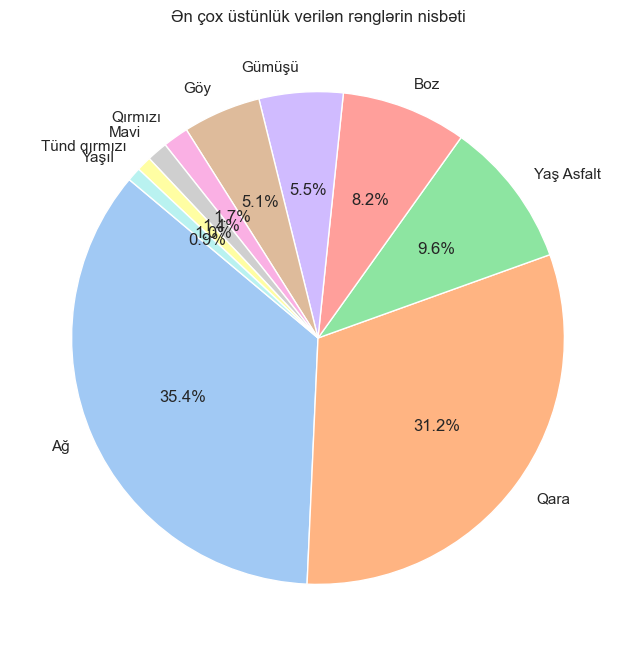

In [67]:
plt.figure(figsize=(8, 8))
color_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title("Ən çox üstünlük verilən rənglərin nisbəti")
plt.ylabel("")
plt.show()

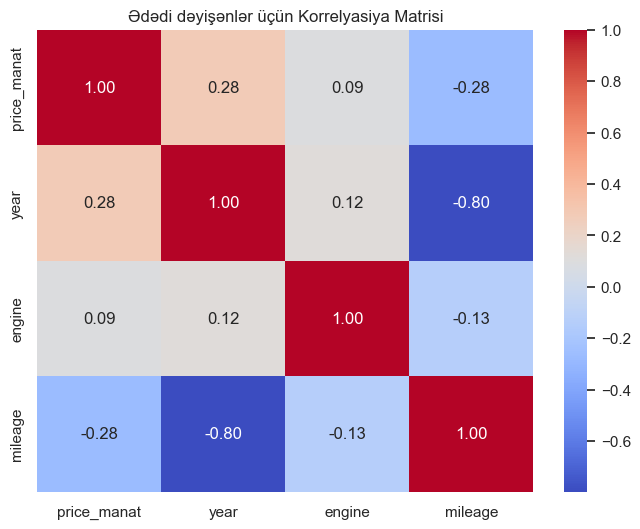

In [69]:
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Ədədi dəyişənlər üçün Korrelyasiya Matrisi")
plt.show()

In [70]:
# year ile mileage arasinda güclü mənfi əlaqə (bir artdıqca digəri azalır)
#  avtomobilin ili qiymete tesir eden ele də güclü amil deyilmiş.
# mühərrik ilə qiymət arasında əlaqə demək olar ki,yoxdur.

# Time Series modeli

In [71]:
# Buraxılış ili üzrə orta qiymət
ts_data = df.groupby("year")["price_manat"].mean().reset_index()

# Tarix sütununa çevir (model üçün lazım deyil, vizual üçün gərəklidir)
ts_data["year"] = pd.to_datetime(ts_data["year"], format="%Y")
ts_data = ts_data.sort_values("year")
ts_data.set_index("year", inplace=True)

ts_data.head()


,price_manat
year,
1990-01-01,4050.000000
1991-01-01,6500.000000
1994-01-01,6600.000000
1995-01-01,6000.000000
1996-01-01,13766.666667


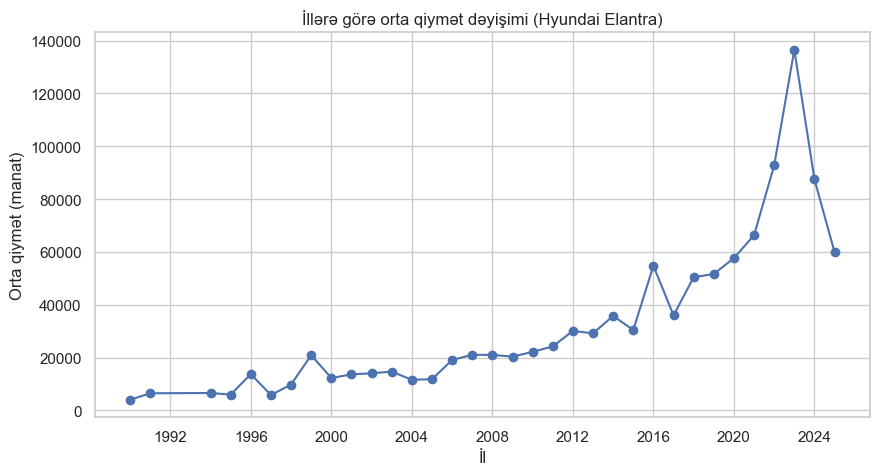

In [72]:
plt.figure(figsize=(10, 5))
plt.plot(ts_data.index, ts_data["price_manat"], marker="o")
plt.title("İllərə görə orta qiymət dəyişimi (Hyundai Elantra)")
plt.xlabel("İl")
plt.ylabel("Orta qiymət (manat)")
plt.grid(True)
plt.show()

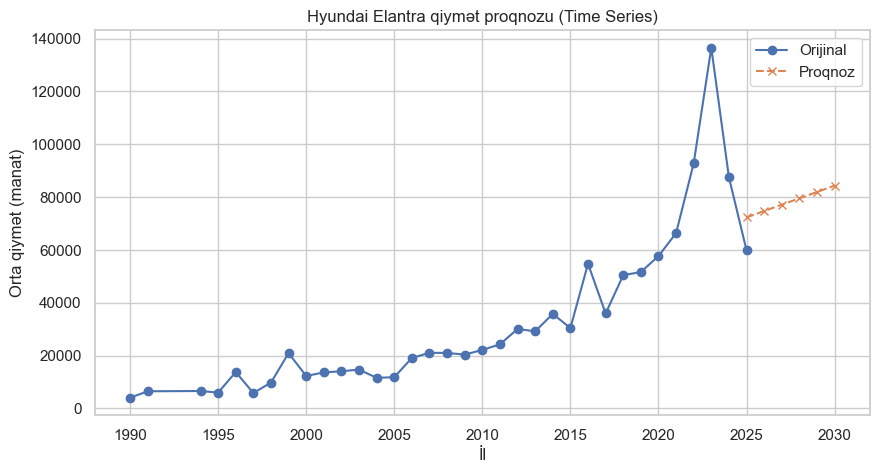

In [73]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Model üçün input hazırlığı
X = ts_data.index.year.values.reshape(-1, 1)
y = ts_data["price_manat"].values

# Model qur
model = LinearRegression()
model.fit(X, y)

# Gələcək illər üçün proqnoz (məs: 2025-2030)
future_years = np.array(range(2025, 2031)).reshape(-1, 1)
future_prices = model.predict(future_years)

# Vizual
plt.figure(figsize=(10, 5))
plt.plot(X, y, label="Orijinal", marker='o')
plt.plot(future_years, future_prices, label="Proqnoz", linestyle="--", marker='x')
plt.title("Hyundai Elantra qiymət proqnozu (Time Series)")
plt.xlabel("İl")
plt.ylabel("Orta qiymət (manat)")
plt.legend()
plt.grid(True)
plt.show()
